# Rapid Mapping for the volcanic eruption in La Palma (Spain)

The Cumbre Vieja volcano on the island of La Palma, Canary Islands, Spain, entered into an eruptive episode on September 19th 2021. When the volcanic activity ended on December 13th 2021, the morphology of the island had changed and thousands of buildings were entirely buried by the lava flow. During its three months duration, the European Union's Copernicus Rapid Mapping program (https://emergency.copernicus.eu/) provided information on the lava flow extent and damage to built-up areas and infrastucture.

This project was inspired by the work performed by the Copernicus Rapid Emergency program and aimed at automating the generation of the following products:
- Extent of the lava flow.
- Number of buildings destroyed by the lava flow.
- Island's morphology change due to the lava flow.
- Store results in a PostgreSQL / PostGIS database. 

Both lidar and satellite images were used for the analyses, downloaded from the following portals:
- Organismo Autónomo Centro Nacional de Información Geográfica (CNIG) del Instituto Geográfico Nacional (IGN) - https://centrodedescargas.cnig.es/CentroDescargas/index.jsp
- Copernicus Emergency Management Service - Mapping. EMSN112: Ground deformation in La Palma Island, Spain. https://emergency.copernicus.eu/mapping/list-of-components/EMSN112


## 1. Import Python libraries

In [18]:
import laspy
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.features import rasterize, shapes
from rasterio.transform import from_bounds
from rasterio.crs import CRS
from rasterio.enums import Resampling
import folium
import pickle
from pathlib import Path
from shapely.geometry import Point, Polygon, MultiPolygon, shape
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from alphashape import alphashape
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sqlalchemy import create_engine
import geoalchemy2
import getpass
import subprocess

## 2. Get Data

In [23]:
# INPUTS
IN_SAMPLE_LAS = Path(r"C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\input\las\extracted_lidar.las")
IN_AOI_LAS = Path(r"C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\input\las\lidar_AOI.las")
IN_IMAGE = Path(r"C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\input\image\sentinel_lava.tif")
# IN_IMAGE = Path(r"C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\input\image\sentinel_2022.tif")
DESIRED_CRS = CRS.from_epsg(32628)
RESOLUTION = 1.75
IN_RASTER_BEFORE = Path(r"C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\input\DTM\before\before_MDT02.tiff")
IN_RASTER_AFTER = Path(r"C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\input\DTM\after\Cumbre_Vieja_DSM_SfM_January_2022_20cm_REGCAN95.tif")

# OUTPUTS
OUT_RASTER_BUILDINGS = Path(r"C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\output\output_raster\test_buildings.tif")
OUT_RASTER_LAVA_CLASSIFICATION = Path(r"C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\output\output_raster\test_classified_lava.tif")
OUT_SHAPEFILE_BUILDINGS_POLYGON = Path(r"C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\output\output_shape\buildings_rasterize\test_buildings_polygon.shp")
OUT_SHAPEFILE_BUILDINGS_POINT = Path(r"C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\output\output_shape\buildings_rasterize\test_buildings_points.shp")
OUT_SHAPEFILE_BUILDINGS_DBSCAN = Path(r"C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\output\output_shape\buildings_dbscan\test_buildings_dbscan.shp")
OUT_SHAPEFILE_LAVAFLOW = Path(r"C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\output\output_shape\lava_flow\test_lava_flow.shp")
OUT_SHAPEFILE_AFFECTED_BUILDINGS = Path(r"C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\output\output_shape\affected_buildings\test_affected_buildings_area.shp")
OUT_SHAPEFILE_AFFECTED_BUILDINGS_POINTS = Path(r"C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\output\output_shape\affected_buildings\test_affected_buildings_point.shp")
OUT_RF_MODEL = Path(r"C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\output\random_forest_classifier\test_RF_model.pickle")
OUT_RASTER_DIFFERENCE = Path(r"C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\output\DTM_difference\difference.tif")

## 3. Define Functions / Processing Workflow

In [3]:
def import_las_to_geoDataFrame(in_file, desired_crs):
    """
    Imports a LAS file and converts it into a Pandas GeoDataFrame.

    Parameters:
        in_file (str): The path to the LAS file to be imported.

    Returns:
        lidar_gdf (GeoDataFrame): A GeoDataFrame containing the LAS data
                                  with x, y, z, classification and geometry columns.
    """
    print("Loading LAS file...")
    las_data = laspy.read(in_file)
    x = np.array(las_data.x)
    y = np.array(las_data.y)
    z = np.array(las_data.z)
    c = np.array(las_data.classification)
    
    df = pd.DataFrame({'x': x,'y': y,'z': z,'classification': c})
    df['geometry'] = df.apply(lambda row: Point(row['x'], row['y']), axis=1)
    lidar_gdf = gpd.GeoDataFrame(df, crs=DESIRED_CRS, geometry=df['geometry']) 
    print("LAS file loaded to a Pandas GeoDataFrame.")
    return lidar_gdf

def random_forest_classifier(lidar_gdf, model_output_path):
    """
    Trains a Random Forest Classifier using lidar data and saves the model to a pickle file.

    Parameters:
        lidar_gdf (GeoDataFrame): A GeoDataFrame containing lidar data with columns for x, y, z,
                                  classification and geometry.
        model_output_path (str): The path to save the trained Random Forest model as a pickle file.

    Returns:
        lidar_classified_gdf (GeoDataFrame): A copy of the input GeoDataFrame with an additional
                                             column ('predicted_classification') that contains the
                                             predicted classifications from the Random Forest model.
    """
    X = lidar_gdf.drop(['classification', 'geometry'], axis=1)
    y = lidar_gdf['classification']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)   
    rf_classifier = RandomForestClassifier()
    print("Fitting Random Forest Classifier Model...")
    rf_classifier.fit(X_train, y_train)
    y_pred = rf_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Random Forest accuracy: {accuracy}")
    with open(model_output_path, 'wb') as file:
        pickle.dump(rf_classifier, file)    
    print(f'Random Forest Model Pickle File saved: {model_output_path}')
    
    lidar_classified_gdf = lidar_gdf.copy()
    lidar_classified_gdf['predicted_classification'] = rf_classifier.predict(X)
    
    return lidar_classified_gdf

def random_forest_classifier_from_pickle(lidar_gdf, model_output_path):
    """
    Loads a trained Random Forest Classifier from a pickle file and uses it to predict classifications for a Lidar GeoDataFrame.

    Args:
        lidar_gdf (GeoDataFrame): A GeoDataFrame containing Lidar data.
        model_output_path (str): The file path to the trained Random Forest Classifier pickle file.

    Returns:
        None
    """
    X = lidar_gdf.drop(['classification', 'geometry'], axis=1)
    print(f"Loading Random Forest Model from Pickle File: {model_output_path}")
    with open(OUT_RF_MODEL, 'rb') as file:
        rf_classifier = pickle.load(file)
    print("Predicting Classifications...")
    lidar_classified_gdf = lidar_gdf.copy()
    lidar_classified_gdf['predicted_classification'] = rf_classifier.predict(X)
    print("Prediction completed.")
    return lidar_classified_gdf
    
def buildings_to_polygon(lidar_classified_gdf, resolution, desired_crs, output_raster, output_shape_buildings, output_shape_buildings_points):
    """
    Converts classified building points from a lidar GeoDataFrame into polygons and saves them as an ESRI Shapefile.

    Parameters:
        lidar_classified_gdf (GeoDataFrame): A GeoDataFrame containing classified lidar data with columns
                                             for x, y, z, classification, geometry and predicted_classification.
        resolution (float): The resolution (pixel size) to be used for rasterization.
        desired_crs (str): The desired CRS (Coordinate Reference System) for the output GeoDataFrames.
        output_raster (str): The path to save the rasterized building points as a GeoTIFF raster file.
        output_shape_buildings (str): The path to save the buildings polygons as an ESRI Shapefile.
        output_shape_buildings_points (str): The path to save the buildings centroids as an ESRI Shapefile.

    Returns:
        buildings_filtered_gdf (GeoDataFrame): A GeoDataFrame containing the buildings polygons
                                               with columns for polygons, centroids and area.
    """    
    building_points_gdf = lidar_classified_gdf[lidar_classified_gdf['predicted_classification']==6]
    bounds = building_points_gdf.total_bounds
    rows = int((bounds[3] - bounds[1]) / resolution)
    cols = int((bounds[2] - bounds[0]) / resolution)

    output_profile = {
        'driver': 'GTiff',
        'dtype': np.uint8,
        'count': 1,
        'width': cols,
        'height': rows,
        'transform': from_bounds(*bounds, cols, rows),
        'crs': DESIRED_CRS,
    }

    raster = np.zeros((output_profile['height'], output_profile['width']), dtype=output_profile['dtype'])

    rasterized = rasterize(
        shapes=building_points_gdf.geometry,
        out=raster,
        transform=output_profile['transform'],
        fill=0,
        default_value=255,
        dtype=output_profile['dtype'],
    )

    with rasterio.open(output_raster, 'w', **output_profile) as dst:
        dst.write(rasterized, 1)
    print(f'Building Raster saved: {output_raster}')
    
    polygons = []
    for polygon, value in shapes(raster, mask=raster == 255, transform=output_profile['transform']):
        if value == 255:
            polygons.append(shape(polygon))
            
    buildings_gdf = gpd.GeoDataFrame({'geometry': polygons}, crs=desired_crs)
    buildings_gdf = buildings_gdf.rename_geometry('polygons')
    buildings_gdf['centroids'] = buildings_gdf.centroid
    buildings_gdf['area'] = buildings_gdf.area
    
    buildings_filtered_gdf = buildings_gdf[buildings_gdf.area > 10]
    buildings_filtered_gdf['polygons'].to_file(output_shape_buildings, driver='ESRI Shapefile')
    buildings_filtered_gdf['centroids'].to_file(output_shape_buildings_points, driver='ESRI Shapefile')
    print(f'Building Shapefiles saved: {output_shape_buildings}, {output_shape_buildings_points}')
    return buildings_filtered_gdf

def buildings_to_polygon_dbscan(lidar_classified_gdf, desired_crs, out_shapefile_buildings_dbscan):
    """
    Converts classified building points from a lidar GeoDataFrame into polygons using DBSCAN algorithm and saves them as an ESRI Shapefile.

    Parameters:
        lidar_classified_gdf (GeoDataFrame): A GeoDataFrame containing classified lidar data with columns
                                             for x, y, z, classification, geometry and predicted_classification.
        desired_crs (str): The desired CRS (Coordinate Reference System) for the output GeoDataFrame.
        out_shapefile_buildings_dbscan (str): The path to save the buildings polygons generated by DBSCAN as an ESRI Shapefile.

    Returns:
        buildings_polygon_gdf (GeoDataFrame): A GeoDataFrame containing the polygons of the buildings generated by DBSCAN
                                              with the cluster labels.
    """  
    gdf_dbscan = lidar_classified_gdf[lidar_classified_gdf['predicted_classification'] == 6]
    gdf_dbscan = gdf_dbscan[['x','y','geometry']]
    coords = gdf_dbscan[['x', 'y']].values
    scaler = StandardScaler()
    coords_scaled = scaler.fit_transform(coords)

    eps = 0.1 
    min_samples = 5  
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(coords_scaled)

    gdf_dbscan['cluster'] = clusters

    polygons = []

    gdf_clusters = gdf_dbscan[gdf_dbscan['cluster'] != -1]

    for cluster_label in gdf_clusters['cluster'].unique():
        cluster_coords = gdf_clusters.loc[gdf_clusters['cluster'] == cluster_label, ['x', 'y']].values
        outline_polygon = Polygon(cluster_coords).convex_hull
        polygons.append(outline_polygon)

    buildings_polygon_gdf = gpd.GeoDataFrame(geometry=polygons, index=gdf_clusters['cluster'].unique(), crs=desired_crs)

    buildings_polygon_gdf.to_file(out_shapefile_buildings_dbscan, driver='ESRI Shapefile')
    print(f'Building Shapefiles saved: {out_shapefile_buildings_dbscan}')
    return buildings_polygon_gdf

def lava_cluster_plotter(in_image, out_raster_lava_classification):
    """
    Perform K-means clustering on a satellite image and save the cluster image as a GeoTIFF file.

    Parameters:
        in_image (str): Path to the input raster image.
        out_raster_lava_classification (str): Path to save the output cluster image as a GeoTIFF file.

    Returns:
        lava_classified_gdf (GeoDataFrame): GeoDataFrame containing the K-Means cluster assignments.
    """    
    image = rasterio.open(in_image)
    band_index = 1  
    band = image.read(band_index)

    X = band.reshape((-1,1))

    k_means = KMeans(n_clusters=10)
    k_means.fit(X)

    clusters = k_means.labels_
    clusters = clusters.reshape(band.shape)
    
    coords = []
    for i in range(image.height):
        for j in range(image.width):
            lon, lat = image.xy(i, j)
            coords.append(Point(lon, lat))
        
    lava_classified_df = pd.DataFrame({'geometry': coords, 'cluster_kmeans': clusters.flatten()})

    lava_classified_gdf = gpd.GeoDataFrame(lava_classified_df, crs=image.crs)

    metadata = image.meta
    metadata.update({
        'count': 1,  
        'dtype': rasterio.uint8, 
        'compress': 'lzw',  
         'nodata': 0,  
    })

    with rasterio.open(out_raster_lava_classification, 'w', **metadata) as dst:
        dst.write(clusters.astype(rasterio.uint8), 1)
    print(f'Lava Clusters GeoTIFF file saved: {out_raster_lava_classification}')

    plt.figure(figsize=(20,20))
    plt.imshow(clusters, cmap="Set1")
    plt.colorbar(label='Classification')
    plt.show()
    
    return lava_classified_gdf   
    
def lava_extractor(lava_classified_gdf, out_shapefile_lavaflow, OUT_SHAPEFILE_LAVAFLOW):
    """
    Extract a lava flow polygon from a cluster in a GeoDataFrame using DBSCAN clustering.

    Parameters:
        lava_classified_gdf (GeoDataFrame): GeoDataFrame containing cluster assignments and coordinates.
        out_shapefile_lavaflow (str): Path to save the output shapefile containing the lava flow polygon.

    Returns:
        lava_polygon_gdf (GeoDataFrame): GeoDataFrame containing the extracted lava flow polygon.
    """
    cluster_number = int(input('Enter the K-Means cluster number representing the lava flow:'))
    lava_gdf = lava_classified_gdf[lava_classified_gdf['cluster_kmeans'] == cluster_number].copy()
    lava_gdf['x'] = lava_gdf['geometry'].x
    lava_gdf['y'] = lava_gdf['geometry'].y
    
    # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=100, min_samples=100)
    labels = dbscan.fit_predict(lava_gdf[['x', 'y']])
    
    # Assign cluster labels to the original GeoDataFrame
    lava_gdf['cluster_dbscan'] = labels
    
    # Visualize the cluster labels
    fig, ax = plt.subplots(figsize=(10, 10))
    lava_gdf.plot(column='cluster_dbscan', cmap='Set1', ax=ax, legend=True)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('DBSCAN Clustering')
    plt.show()
    
    final_lava_gdf = lava_gdf[lava_gdf['cluster_dbscan'] == 0]
    
    # Visualize the cluster labels
    fig, ax = plt.subplots(figsize=(10, 10))
    final_lava_gdf.plot(column='cluster_dbscan', cmap='Set1', ax=ax, legend=True)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Extracted Lava Flow')
    plt.show()
    
    # Extract the coordinates from the geometry column
    points = final_lava_gdf.geometry.apply(lambda geom: (geom.x, geom.y)).tolist()
    
    # Compute the concave hull using alpha shape
    alpha = 0.1  # Adjust the alpha value to control the level of concavity
    concave_hull = alphashape(points, alpha)
    
    # Create a new GeoDataFrame for the concave hull polygon
    lava_polygon_gdf = gpd.GeoDataFrame(geometry=[concave_hull], crs=lava_classified_gdf.crs)
    
    lava_polygon_gdf.to_file(out_shapefile_lavaflow, driver='ESRI Shapefile')
    print(f'Lava Flow Shapefile saved: {out_shapefile_lavaflow}')
    
    return lava_polygon_gdf

def affected_buildings(buildings_filtered_gdf, lava_polygon_gdf, out_shapefile_affected_buildings, out_shapefile_affected_buildings_points):
    """
    Identify the buildings affected by a lava flow and save them as an ESRI Shapefile.

    Parameters:
        buildings_filtered_gdf (GeoDataFrame): GeoDataFrame containing the buildings to be analyzed.
        lava_polygon_gdf (GeoDataFrame): GeoDataFrame representing the lava flow polygon.
        out_shapefile_affected_buildings (str): Path to save the output ESRI Shapefile containing the affected building polygons.
        out_shapefile_affected_buildings_points (str): Path to save the output ESRI Shapefile containing the centroids of the affected buildings.

    Returns:
        buildings_w_lava_gdf (GeoDataFrame): GeoDataFrame containing the affected buildings.
    """
    buildings_w_lava_gdf = gpd.sjoin(buildings_filtered_gdf, lava_polygon_gdf, predicate="intersects")
    print(f"Total affected buildings: {len(buildings_w_lava_gdf)}")
    buildings_w_lava_gdf['polygons'].to_file(out_shapefile_affected_buildings, driver='ESRI Shapefile')
    buildings_w_lava_gdf['centroids'].to_file(out_shapefile_affected_buildings_points, driver='ESRI Shapefile')
    print(f'Affected Buildings Shapefiles saved: {out_shapefile_affected_buildings} , {out_shapefile_affected_buildings_points}')
    return buildings_w_lava_gdf    

def elevation_change(in_raster_before, in_raster_after, out_raster_difference):
    """
    Calculate the elevation change between two input raster files and save the difference as a GeoTIFF.

    Parameters:
        in_raster_before (Path): Path to the input raster file representing elevation data before the event.
        in_raster_after (Path): Path to the input raster file representing elevation data after the event.
        out_raster_difference (Path): Path to save the output GeoTIFF file containing the elevation change.

    """
    src1 = rasterio.open(in_raster_before)
    src2 = rasterio.open(in_raster_after)

    # Reproject the second raster to match the resolution and extent of the first raster
    data2, _ = rasterio.warp.reproject(
        source=rasterio.band(src2, 1),
        destination=np.empty_like(src1.read(1)),
        src_transform=src2.transform,
        src_crs=src2.crs,
        dst_transform=src1.transform,
        dst_crs=src1.crs,
        resampling=Resampling.bilinear)

    # Read the input raster data
    data1 = src1.read(1)

    # Compute the difference between the rasters
    diff = data1 - data2

    # Replace inf and NaN values with a valid nodata value
    diff[np.isinf(diff) | np.isnan(diff)] = src1.nodata

    # Prepare the output GeoTIFF file
    output_profile = src1.profile
    output_profile.update(count=1)  # Update band count

    # Create the output file
    with rasterio.open(out_raster_difference, 'w', **output_profile) as dst:
        # Write the difference data to the output file
        dst.write(diff, 1)
    print(f'Elevation Change GeoTIFF saved: {out_raster_difference}')

    # Close the input files
    src1.close()
    src2.close()
    
def import_geoDataFrame_to_database(input_gdf,table_name):
    """
    Imports a Pandas GeoDataFrame into a PostGIS database table.

    Parameters:
        input_gdf (GeoDataFrame): The Pandas GeoDataFrame containing the spatial data to be imported.
        table_name (str): The name of the PostGIS database table to import the data into.

    Returns:
        None
    """
    password = getpass.getpass('Enter the database password:')
    engine = create_engine('postgresql://postgres:' + password + '@localhost:5432/la_palma')
    input_gdf.to_postgis(table_name, con=engine)
    print(f'GeoDataFrame {input_gdf} saved to the PostGIS database table {table_name}')
    
def import_raster_to_database(input_raster, table_name):
    """
    Imports a raster dataset into a PostGIS database table.

    Parameters:
        input_raster (str): The file path to the raster dataset to be imported.
        table_name (str): The name of the PostGIS database table to import the raster into.

    Returns:
        None

    """
    host = 'localhost'
    port = '5432'
    database = 'la_palma'
    username = 'postgres'
    password = getpass.getpass('Enter the database password:')

    # Define the command to run, including any necessary arguments
    command_raster2pgsql = [
        r"C:\Program Files\PostgreSQL\15\bin\raster2pgsql.exe", '-I', '-C', '-M', input_raster
    ]
    command_psql = [
        r"C:\Program Files\PostgreSQL\15\bin\psql.exe", '-h', host, '-p', port, '-d', database, '-U', username,
        '--password', password
    ]

    # Run the raster2pgsql command and capture the output
    process_raster2pgsql = subprocess.Popen(command_raster2pgsql, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output_raster2pgsql, error_raster2pgsql = process_raster2pgsql.communicate()

    # Check the return code of raster2pgsql command
    if process_raster2pgsql.returncode == 0:
        # Run the psql command and capture the output
        process_psql = subprocess.Popen(command_psql, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        output_psql, error_psql = process_psql.communicate(input=output_raster2pgsql)
        
        # Check the return code of psql command
        if process_psql.returncode == 0:
            print(f'Raster file {input_raster} saved to the PostGIS database table {table_name}')
        else:
            print('An error occurred in psql command:', error_psql.decode())
    else:
        print('An error occurred in raster2pgsql command:', error_raster2pgsql.decode())
        
def main():
    """
    Executes the main workflow for processing lidar and image data.

    Parameters:
        None

    Returns:
        None
    """
    lidar_gdf = import_las_to_geoDataFrame(IN_AOI_LAS, DESIRED_CRS)
    lidar_classified_gdf = random_forest_classifier_from_pickle(lidar_gdf, OUT_RF_MODEL)
    buildings_filtered_gdf = buildings_to_polygon(lidar_classified_gdf, RESOLUTION, DESIRED_CRS, OUT_RASTER_BUILDINGS, OUT_SHAPEFILE_BUILDINGS_POLYGON, OUT_SHAPEFILE_BUILDINGS_POINT)
    lava_classified_gdf = lava_cluster_plotter(IN_IMAGE, OUT_RASTER_LAVA_CLASSIFICATION) 
    lava_polygon_gdf = lava_extractor(lava_classified_gdf, OUT_SHAPEFILE_LAVAFLOW)
    buildings_w_lava_gdf = affected_buildings(buildings_filtered_gdf, lava_classified_gdf, OUT_SHAPEFILE_AFFECTED_BUILDINGS, OUT_SHAPEFILE_AFFECTED_BUILDINGS_POINTS)
    elevation_change(IN_RASTER_BEFORE, IN_RASTER_AFTER, OUT_RASTER_DIFFERENCE)
    import_geoDataFrame_to_database(buildings_filtered_gdf, 'buildings')
    import_geoDataFrame_to_database(lava_polygon_gdf, 'lava_flow')
    import_geoDataFrame_to_database(buildings_w_lava_gdf, 'affected_buildings')
    # import_raster_to_database(OUT_RASTER_DIFFERENCE, 'elevation_raster')    

## 4. Execute Processing Workflow

### 4.1. Import LAS to GeoDataFrame

Imports a LAS file and converts it into a Pandas GeoDataFrame.

In [4]:
print("Loading LAS file...")
las_data = laspy.read(IN_SAMPLE_LAS)
x = np.array(las_data.x)
y = np.array(las_data.y)
z = np.array(las_data.z)
c = np.array(las_data.classification)
df = pd.DataFrame({
    'x': x,
    'y': y,
    'z': z,
    'classification': c,   
})
df['geometry'] = df.apply(lambda row: Point(row['x'], row['y']), axis=1)
lidar_gdf = gpd.GeoDataFrame(df, crs=DESIRED_CRS, geometry=df['geometry'])
print("LAS file loaded")

Loading LAS file...
LAS file loaded


In [5]:
lidar_gdf

x           y       z  classification  \
0      214897.42  3168508.29  196.63               1   
1      214963.63  3168562.44  215.30               2   
2      214991.30  3168469.24  216.00               3   
3      214995.61  3168604.28  227.51               2   
4      214906.41  3168485.27  204.54               3   
...          ...         ...     ...             ...   
36575  214999.04  3168630.44  239.56               2   
36576  214994.81  3168627.87  238.60               3   
36577  214992.51  3168631.03  239.51               2   
36578  214999.38  3168626.41  237.88               2   
36579  214989.20  3168630.77  238.76               2   

                             geometry  
0      POINT (214897.420 3168508.290)  
1      POINT (214963.630 3168562.440)  
2      POINT (214991.300 3168469.240)  
3      POINT (214995.610 3168604.280)  
4      POINT (214906.410 3168485.270)  
...                               ...  
36575  POINT (214999.040 3168630.440)  
36576  POINT (214994.810 3168627.870)  
36577  POINT (214992.510 3168631.030)  
36578  POINT (214999.380 3168626.410)  
36579  POINT (214989.200 3168630.770)  

[36580 rows x 5 columns]

In [103]:
# fig, ax = plt.subplots(figsize=(10, 8)) 
# gdf.plot(ax=ax, column='classification', cmap='rainbow', legend=True,  markersize=3)

# plt.title('Classification')  
# ax.set_xlabel('X')
# ax.set_xticklabels(ax.get_xticks(), rotation=90)
# ax.set_ylabel('Y')

# ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

# plt.show()

In [104]:
# lidar_gdf.explore(
#     column="classification", 
#     tooltip="z", 
#     popup=True,
#     cmap="Set1"  
# )

### 4.2. Random Forest Classifier

Trains a Random Forest Classifier using lidar data and saves the model to a pickle file.

In [6]:
X = lidar_gdf.drop(['classification', 'geometry'], axis=1)
y = lidar_gdf['classification']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest accuracy: {accuracy}")
with open(OUT_RF_MODEL, 'wb') as file:
        pickle.dump(rf_classifier, file)    
print(f'Random Forest Picke File saved: {OUT_RF_MODEL}')   
lidar_classified_gdf = lidar_gdf.copy()
lidar_classified_gdf['predicted_classification'] = rf_classifier.predict(X)    

Random Forest accuracy: 0.8638600328048114
Random Forest Picke File saved: C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\output\random_forest_classifier\test_RF_model.pickle


In [7]:
lidar_classified_gdf

x           y       z  classification  \
0      214897.42  3168508.29  196.63               1   
1      214963.63  3168562.44  215.30               2   
2      214991.30  3168469.24  216.00               3   
3      214995.61  3168604.28  227.51               2   
4      214906.41  3168485.27  204.54               3   
...          ...         ...     ...             ...   
36575  214999.04  3168630.44  239.56               2   
36576  214994.81  3168627.87  238.60               3   
36577  214992.51  3168631.03  239.51               2   
36578  214999.38  3168626.41  237.88               2   
36579  214989.20  3168630.77  238.76               2   

                             geometry  predicted_classification  
0      POINT (214897.420 3168508.290)                         1  
1      POINT (214963.630 3168562.440)                         2  
2      POINT (214991.300 3168469.240)                         3  
3      POINT (214995.610 3168604.280)                         2  
4      POINT (214906.410 3168485.270)                         3  
...                               ...                       ...  
36575  POINT (214999.040 3168630.440)                         2  
36576  POINT (214994.810 3168627.870)                         3  
36577  POINT (214992.510 3168631.030)                         2  
36578  POINT (214999.380 3168626.410)                         2  
36579  POINT (214989.200 3168630.770)                         2  

[36580 rows x 6 columns]

In [40]:
# 2.1 random_forest_classifier_from_pickle
# Loads a trained Random Forest Classifier from a pickle file and uses it to predict classifications for a Lidar GeoDataFrame.

# X = lidar_gdf.drop(['classification', 'geometry'], axis=1)
# print(f"Loading Random Forest Model from Pickle File: {model_output_path}")
# with open(OUT_RF_MODEL, 'rb') as file:
#     rf_classifier = pickle.load(file)
# print("Predicting Classifications...")
# lidar_classified_gdf = lidar_gdf.copy()
# lidar_classified_gdf['predicted_classification'] = rf_classifier.predict(X)
# print("Prediction completed.")
# lidar_classified_gdf

Accuracy: 0.8627665390924002


### 4.3. Buildings to Polygon

Converts classified building points from a lidar GeoDataFrame into polygons and saves them as an ESRI Shapefile.

In [38]:
building_points_gdf = lidar_classified_gdf[lidar_classified_gdf['predicted_classification']==6]

bounds = building_points_gdf.total_bounds
rows = int((bounds[3] - bounds[1]) / RESOLUTION)
cols = int((bounds[2] - bounds[0]) / RESOLUTION)
output_profile = {
    'driver': 'GTiff',
    'dtype': np.uint8,
    'count': 1,
    'width': cols,
    'height': rows,
    'transform': from_bounds(*bounds, cols, rows),
    'crs': DESIRED_CRS,
}

raster = np.zeros((output_profile['height'], output_profile['width']), dtype=output_profile['dtype'])
rasterized = rasterize(
    shapes=building_points_gdf.geometry,
    out=raster,
    transform=output_profile['transform'],
    fill=0,
    default_value=255,
    dtype=output_profile['dtype'],
)

with rasterio.open(OUT_RASTER_BUILDINGS, 'w', **output_profile) as dst:
    dst.write(rasterized, 1)
print(f'Building Raster saved: {OUT_RASTER_BUILDINGS}')

polygons = []
for polygon, value in shapes(raster, mask= raster == 255, transform=output_profile['transform']):
    if value == 255:
        polygons.append(shape(polygon))

buildings_gdf = gpd.GeoDataFrame({'geometry': polygons}, crs=DESIRED_CRS)
buildings_gdf = buildings_gdf.rename_geometry('polygons')
buildings_gdf['centroids'] = buildings_gdf.centroid
buildings_gdf['area'] = buildings_gdf.area

buildings_filtered_gdf = buildings_gdf[buildings_gdf.area > 20]
buildings_filtered_gdf['polygons'].to_file(OUT_SHAPEFILE_BUILDINGS_POLYGON, driver='ESRI Shapefile')
buildings_filtered_gdf['centroids'].to_file(OUT_SHAPEFILE_BUILDINGS_POINT, driver='ESRI Shapefile')
print(f'Building Shapefiles saved: {OUT_SHAPEFILE_BUILDINGS_POLYGON}, {OUT_SHAPEFILE_BUILDINGS_POINT}')

Building Raster saved: C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\output\output_raster\test_buildings.tif
Building Shapefiles saved: C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\output\output_shape\buildings_rasterize\test_buildings_polygon.shp, C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\output\output_shape\buildings_rasterize\test_buildings_points.shp


In [13]:
building_points_gdf

x           y       z  classification  \
17     214957.09  3168539.59  215.67               6   
42     215020.11  3168514.89  227.54               6   
44     214928.72  3168496.93  212.32               6   
66     214954.04  3168573.26  224.03               6   
77     214951.99  3168560.82  217.03               6   
...          ...         ...     ...             ...   
36439  214951.30  3168566.04  217.36               6   
36441  214930.65  3168604.23  215.59               6   
36468  215007.21  3168530.99  232.08               6   
36489  214931.75  3168519.74  213.19               6   
36500  214968.62  3168583.90  222.62               6   

                             geometry  predicted_classification  
17     POINT (214957.090 3168539.590)                         6  
42     POINT (215020.110 3168514.890)                         6  
44     POINT (214928.720 3168496.930)                         6  
66     POINT (214954.040 3168573.260)                         6  
77     POINT (214951.990 3168560.820)                         6  
...                               ...                       ...  
36439  POINT (214951.300 3168566.040)                         6  
36441  POINT (214930.650 3168604.230)                         6  
36468  POINT (215007.210 3168530.990)                         6  
36489  POINT (214931.750 3168519.740)                         6  
36500  POINT (214968.620 3168583.900)                         6  

[1794 rows x 6 columns]

In [40]:
buildings_filtered_gdf

polygons  \
0   POLYGON ((214928.265 3168608.190, 214928.265 3...   
1   POLYGON ((214965.316 3168595.803, 214970.609 3...   
2   POLYGON ((214947.672 3168586.956, 214956.494 3...   
3   POLYGON ((214907.092 3168546.257, 214907.092 3...   
5   POLYGON ((214945.908 3168539.179, 214945.908 3...   
6   POLYGON ((214960.023 3168548.027, 214967.080 3...   
8   POLYGON ((215050.005 3168521.484, 215050.005 3...   
9   POLYGON ((214938.851 3168532.101, 214942.379 3...   
11  POLYGON ((214919.443 3168517.945, 214919.443 3...   
13  POLYGON ((214975.902 3168514.406, 214979.431 3...   
14  POLYGON ((215002.368 3168537.410, 215005.896 3...   
19  POLYGON ((214972.373 3168502.019, 214974.138 3...   
20  POLYGON ((215012.954 3168503.789, 215016.482 3...   
21  POLYGON ((214940.615 3168491.402, 214940.615 3...   
22  POLYGON ((214887.684 3168487.863, 214891.213 3...   
23  POLYGON ((214922.971 3168505.558, 214931.793 3...   

                         centroids        area  
0   POINT (214931.793 3168604.946)   37.464603  
1   POINT (214965.927 3168587.500)  162.346612  
2   POINT (214953.311 3168572.415)  287.228621  
3   POINT (214911.423 3168541.029)   68.685105  
5   POINT (214948.970 3168534.547)   53.074854  
6   POINT (214962.102 3168543.160)   87.417406  
8   POINT (215053.534 3168517.945)   37.464603  
9   POINT (214938.106 3168521.539)  199.811215  
11  POINT (214922.089 3168515.291)   28.098452  
13  POINT (214976.784 3168511.752)   24.976402  
14  POINT (215007.840 3168519.907)  415.232681  
19  POINT (214976.269 3168493.376)  202.933265  
20  POINT (215011.327 3168495.865)  140.492260  
21  POINT (214945.649 3168486.094)  106.149708  
22  POINT (214888.763 3168484.619)   28.098452  
23  POINT (214927.772 3168492.987)  268.496320

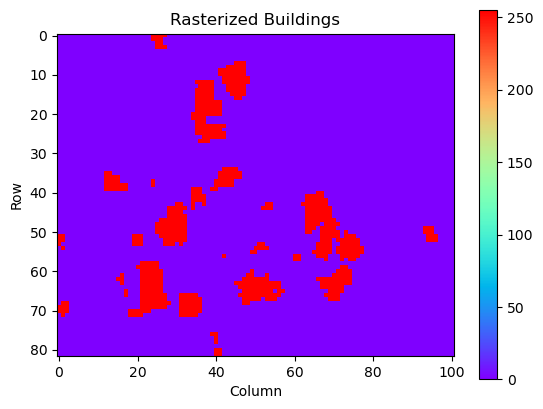

In [41]:
plt.imshow(raster, cmap='rainbow')
plt.title('Rasterized Buildings')
plt.xlabel('Column')
plt.ylabel('Row')
plt.colorbar()
plt.show()

In [1]:
# buildings_filtered_gdf.explore(

# )

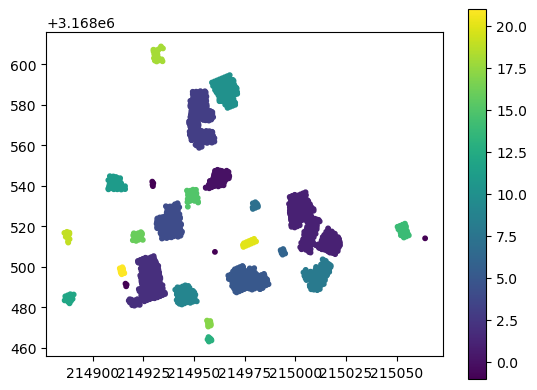

In [18]:
# 3.1. buildings_to_polygon_dbscan
# Converts classified building points from a lidar GeoDataFrame into polygons using DBSCAN algorithm and saves them as an ESRI Shapefile.


# gdf_dbscan = lidar_classified_gdf[lidar_classified_gdf['predicted_classification'] == 6]
# gdf_dbscan = gdf_dbscan[['x', 'y', 'geometry']]
# coords = gdf_dbscan[['x', 'y']].values
# scaler = StandardScaler()
# coords_scaled = scaler.fit_transform(coords)
# eps = 0.1
# min_samples = 5
# dbscan = DBSCAN(eps=eps, min_samples=min_samples)
# clusters = dbscan.fit_predict(coords_scaled)
# gdf_dbscan['cluster'] = clusters
# polygons = []
# gdf_clusters = gdf_dbscan[gdf_dbscan['cluster'] != -1]
# for cluster_label in gdf_clusters['cluster'].unique():
#     cluster_coords = gdf_clusters.loc[gdf_clusters['cluster'] == cluster_label, ['x', 'y']].values
#     outline_polygon = Polygon(cluster_coords).convex_hull
#     polygons.append(outline_polygon)

# buildings_polygon_gdf = gpd.GeoDataFrame(geometry=polygons, index=gdf_clusters['cluster'].unique(), crs=desired_crs)

# buildings_polygon_gdf.to_file(out_shapefile_buildings_dbscan, driver='ESRI Shapefile')
# print(f"Building Shapefiles saved: {out_shapefile_buildings_dbscan}")
# buildings_polygon_gdf

In [2]:
# gdf_dbscan.explore(
#     column="cluster", 
#     tooltip="cluster", 
#     popup=True,
#     cmap="Set1"  
# )

In [3]:
# buildings_polygon_gdf.explore(
#     cmap="Set1"    
# )

### 4.4. Lava Cluster Plotter

Perform K-means clustering on a satellite image and save the cluster image as a GeoTIFF file.

GeoTIFF file saved: C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\output\output_raster\test_classified_lava.tif


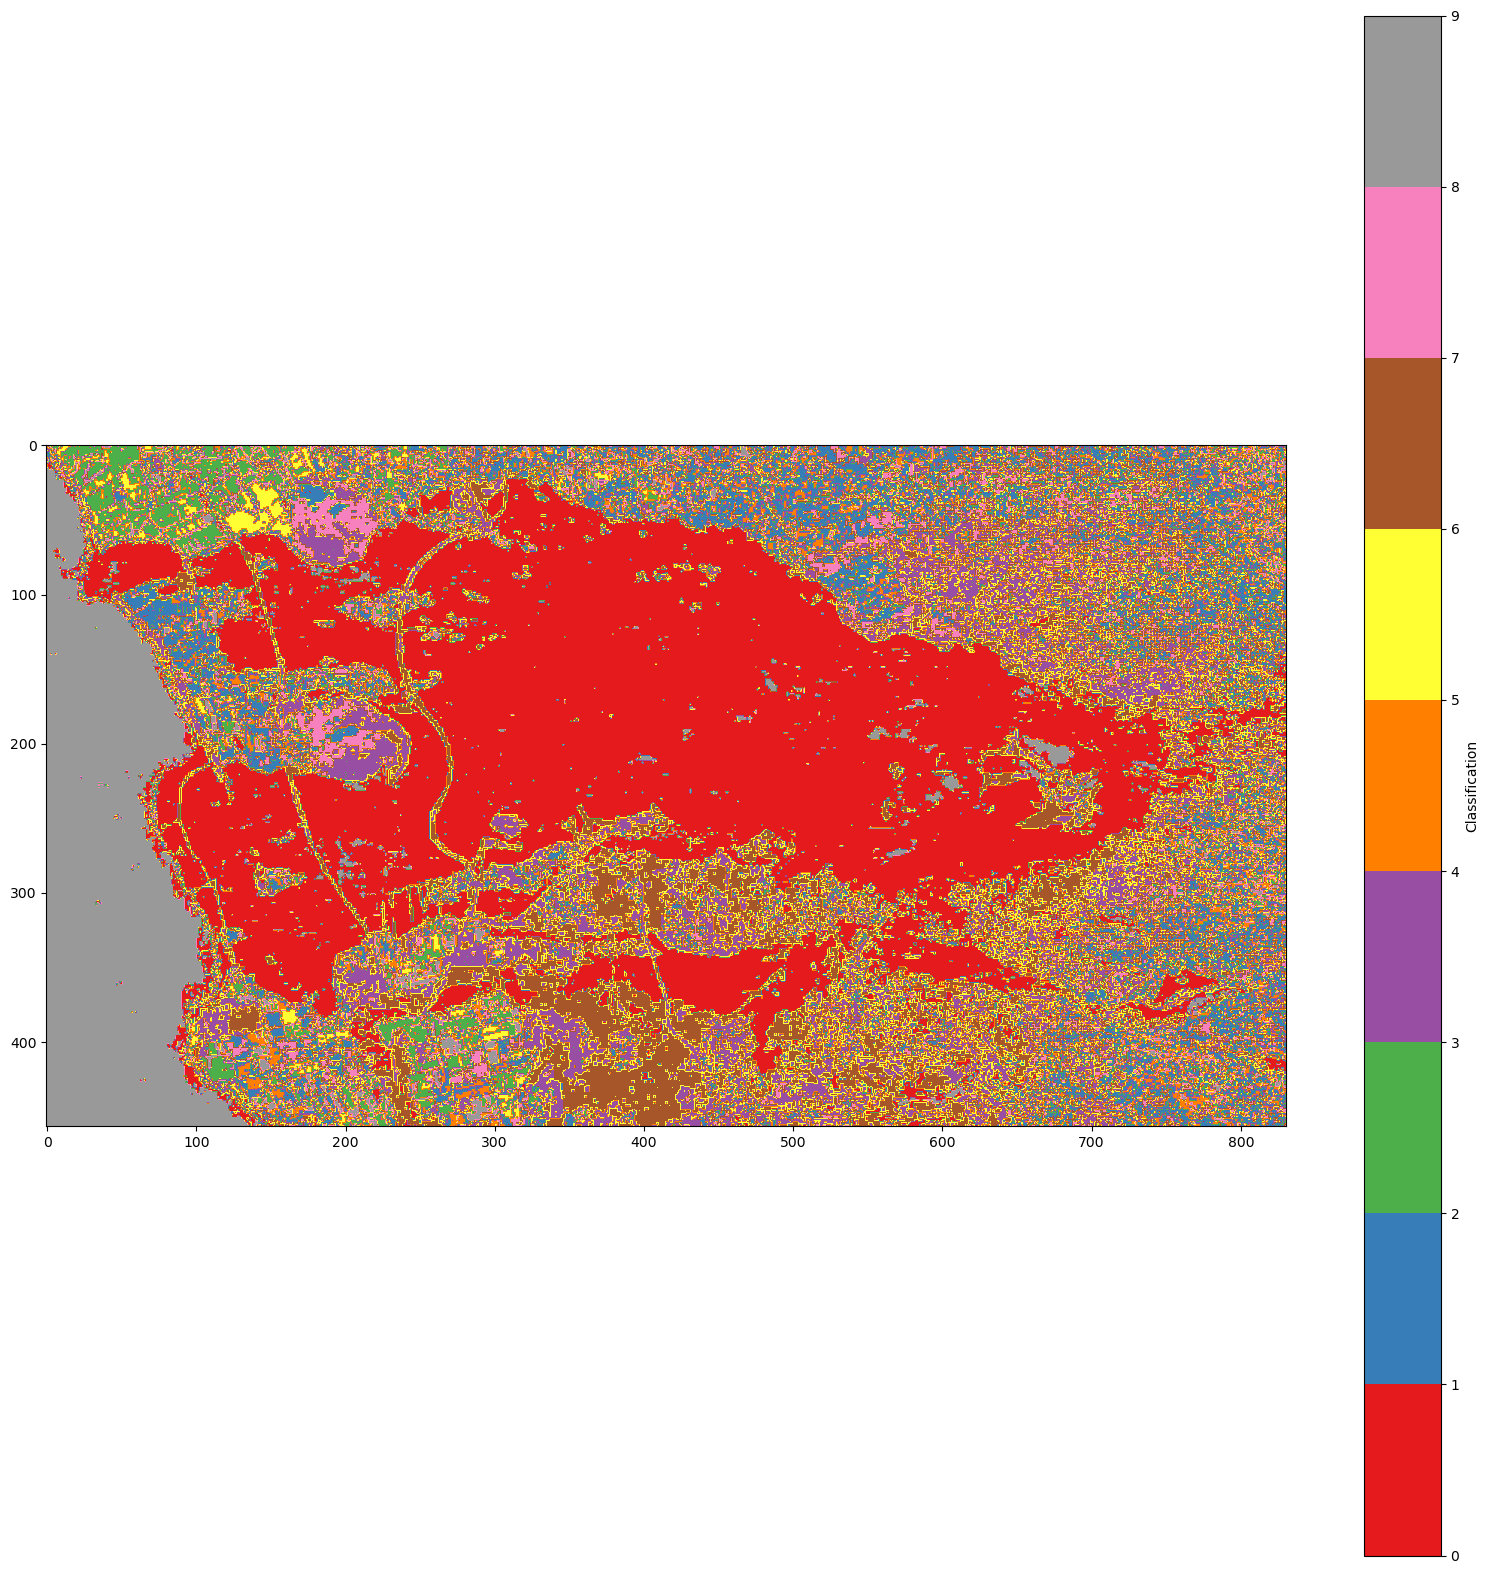

In [11]:
image = rasterio.open(IN_IMAGE)
band_index = 1  
band = image.read(band_index)
X = band.reshape((-1,1))
k_means = KMeans(n_clusters=10)
k_means.fit(X)

clusters = k_means.labels_
clusters = clusters.reshape(band.shape)

# Define the metadata for the new GeoTIFF file
metadata = image.meta
metadata.update({
    'count': 1,  # Number of bands in the output image
    'dtype': rasterio.uint8,  # Data type of the output image
    'compress': 'lzw',  # Compression method for the output image
     'nodata': 0,  # NoData value for the output image
})

# Write the cluster image to the new GeoTIFF file
with rasterio.open(OUT_RASTER_LAVA_CLASSIFICATION, 'w', **metadata) as dst:
    dst.write(clusters.astype(rasterio.uint8), 1)
    
print('GeoTIFF file saved:', OUT_RASTER_LAVA_CLASSIFICATION)

plt.figure(figsize=(20,20))
plt.imshow(clusters, cmap="Set1")
plt.colorbar(label='Classification')
plt.show()


coords = []
for i in range(image.height):
    for j in range(image.width):
        lon, lat = image.xy(i, j)
        coords.append(Point(lon, lat))
        
        
lava_classified_df = pd.DataFrame({'geometry': coords, 'cluster_kmeans': clusters.flatten()})
lava_classified_gdf = gpd.GeoDataFrame(lava_classified_df, crs=image.crs)

In [5]:
lava_classified_gdf

geometry  cluster_kmeans
0       POINT (212698.351 3173157.360)               2
1       POINT (212708.347 3173157.360)               2
2       POINT (212718.343 3173157.360)               2
3       POINT (212728.339 3173157.360)               2
4       POINT (212738.335 3173157.360)               2
...                                ...             ...
589675  POINT (220445.277 3165610.072)               7
589676  POINT (220455.273 3165610.072)               7
589677  POINT (220465.269 3165610.072)               3
589678  POINT (220475.265 3165610.072)               3
589679  POINT (220485.261 3165610.072)               3

[589680 rows x 2 columns]

In [24]:
# classified_gdf = gpd.GeoDataFrame(classified_df, crs=DESIRED_CRS)
# lava_gdf = classified_gdf[classified_gdf['cluster_kmeans']==1]

### 4.5. Lava Extractor

Extract a lava flow polygon from a cluster in a GeoDataFrame using DBSCAN clustering.

Enter the K-Means cluster number representing the lava flow:0


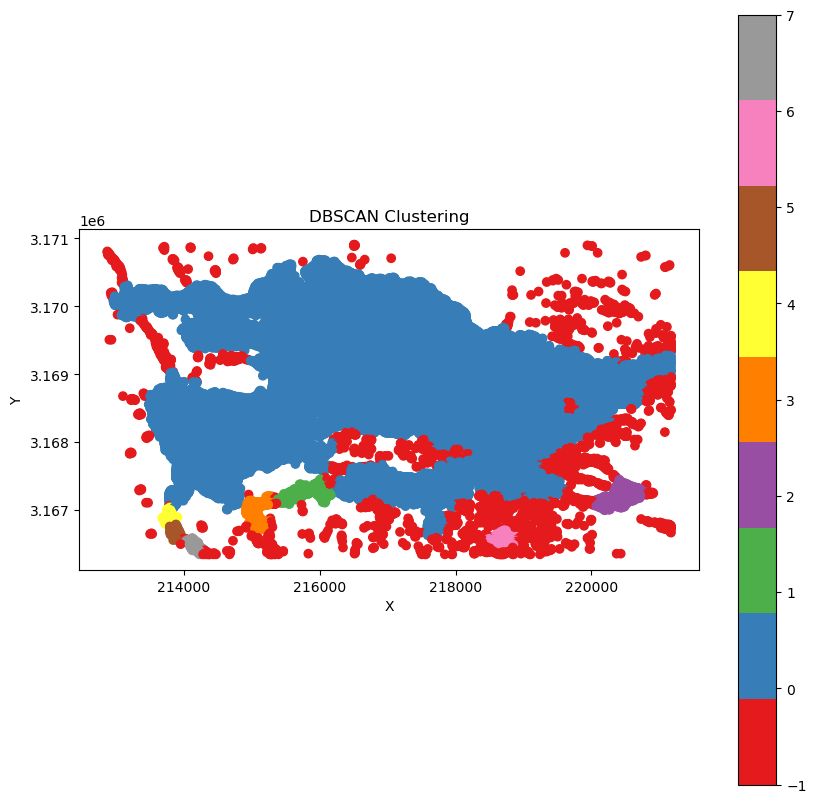

In [13]:
cluster_number = int(input('Enter the K-Means cluster number representing the lava flow:'))
lava_gdf = lava_classified_gdf[lava_classified_gdf['cluster_kmeans'] == cluster_number].copy()
# Extract coordinates from the 'geometry' column
lava_gdf['x'] = lava_gdf['geometry'].x
lava_gdf['y'] = lava_gdf['geometry'].y

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=100, min_samples=100)
labels = dbscan.fit_predict(lava_gdf[['x', 'y']])

# Assign cluster labels to the original GeoDataFrame
lava_gdf['dbscan_cluster'] = labels

# Visualize the cluster labels
fig, ax = plt.subplots(figsize=(10, 10))
lava_gdf.plot(column='dbscan_cluster', cmap='Set1', ax=ax, legend=True)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('DBSCAN Clustering')
plt.show()


In [59]:
lava_gdf

geometry  cluster_kmeans              x  \
363     POINT (216500.408 3170905.000)               5  216500.408152   
364     POINT (216510.408 3170905.000)               5  216510.408152   
1196    POINT (216520.408 3170895.000)               5  216520.408152   
1538    POINT (219940.408 3170895.000)               5  219940.408152   
2025    POINT (216500.408 3170885.000)               5  216500.408152   
...                                ...             ...            ...   
379533  POINT (218840.408 3166345.000)               5  218840.408152   
379534  POINT (218850.408 3166345.000)               5  218850.408152   
379558  POINT (219090.408 3166345.000)               5  219090.408152   
379559  POINT (219100.408 3166345.000)               5  219100.408152   
379573  POINT (219240.408 3166345.000)               5  219240.408152   

                y  dbscan_cluster  
363     3170905.0              -1  
364     3170905.0              -1  
1196    3170895.0              -1  
1538    3170895.0              -1  
2025    3170885.0              -1  
...           ...             ...  
379533  3166345.0              -1  
379534  3166345.0              -1  
379558  3166345.0              -1  
379559  3166345.0              -1  
379573  3166345.0              -1  

[134919 rows x 5 columns]

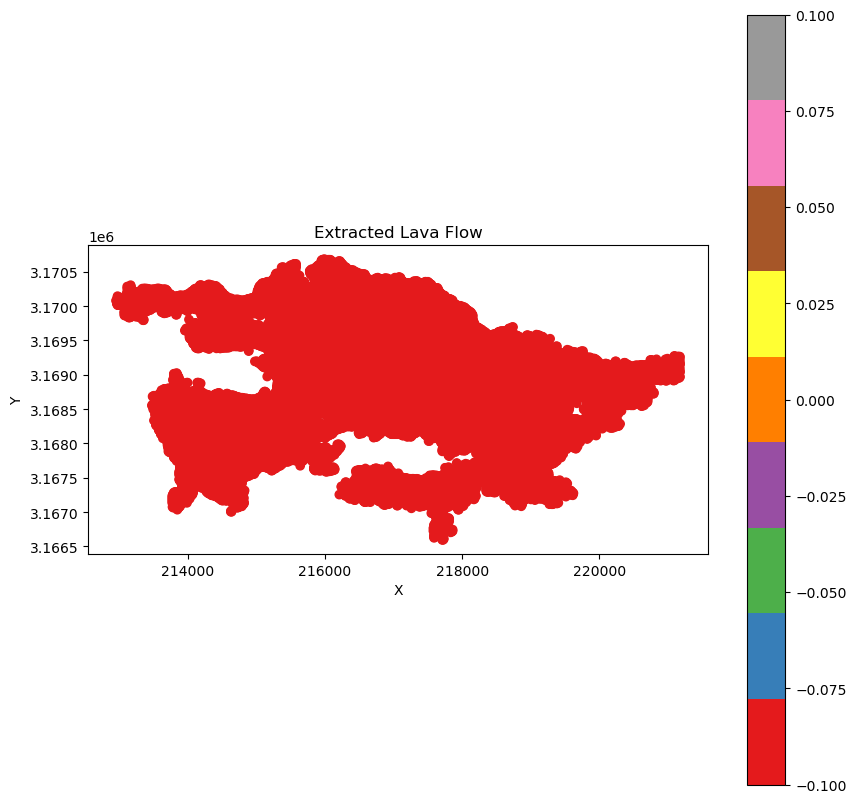

In [14]:
final_lava_gdf = lava_gdf[lava_gdf['dbscan_cluster']==0]
fig, ax = plt.subplots(figsize=(10, 10))
final_lava_gdf.plot(column='dbscan_cluster', cmap='Set1', ax=ax, legend=True)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Extracted Lava Flow')
plt.show()

In [75]:
points = final_lava_gdf.geometry.apply(lambda geom: (geom.x, geom.y)).tolist()
alpha = 0.1 
concave_hull = alphashape(points, alpha)
lava_polygon_gdf = gpd.GeoDataFrame(geometry=[concave_hull], crs=DESIRED_CRS)
lava_polygon_gdf.to_file(OUT_SHAPEFILE_LAVAFLOW, driver='ESRI Shapefile')
print(f'Lava Flow Shapefile saved: {OUT_SHAPEFILE_LAVAFLOW}')

Lava Flow Shapefile saved: C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\output\output_shape\lava_flow\test_lava_flow.shp


<AxesSubplot:>

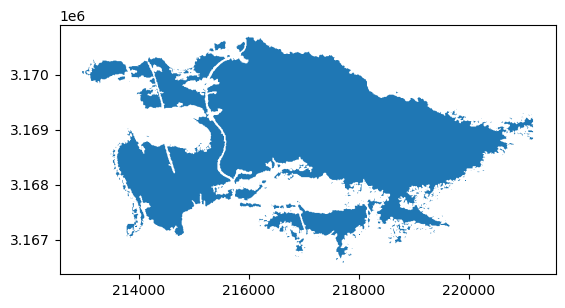

In [76]:
lava_polygon_gdf.plot()

In [34]:
# lava_polygon_gdf.to_file(OUT_SHAPE3, driver='ESRI Shapefile')

In [126]:
# lava_gdf_filtered.explore(

#     cmap="Set1"  
# )

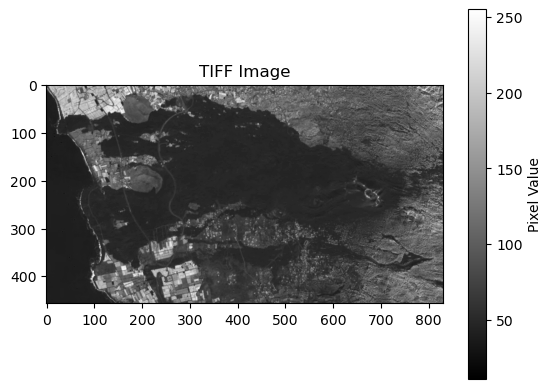

In [35]:
plt.imshow(band, cmap='gray')
plt.title('TIFF Image')
plt.colorbar(label='Pixel Value')
plt.show()

In [5]:
# lava_polygon_gdf.explore(

#     cmap="Set1"  
# )

In [4]:
# m = lava_polygon_gdf.explore(
#     color="black",  
#     name="LAVA FLOW" 
# )


# buildings_polygon_gdf.explore(
#     m=m,
#     color= "blue",
#     name="DBSCAN"
# )
    
# buildings_rasterize_gdf.explore(
#     m=m,  
#     color="red",  
#     name="RASTERIZE"
# )

# folium.LayerControl().add_to(m)  
# m  

### 4.6. Affected Buildings

Identify the buildings affected by a lava flow and save them as an ESRI Shapefile.

In [41]:
buildings_w_lava = gpd.sjoin(buildings_filtered_gdf, lava_polygon_gdf, predicate="intersects")
print(f"Total affected buildings: {len(buildings_w_lava)}")
buildings_w_lava['polygons'].to_file(OUT_SHAPEFILE_AFFECTED_BUILDINGS, driver='ESRI Shapefile')
buildings_w_lava['centroids'].to_file(OUT_SHAPEFILE_AFFECTED_BUILDINGS_POINTS, driver='ESRI Shapefile')
print(f'Affected Buildings Shapefiles saved: {OUT_SHAPEFILE_AFFECTED_BUILDINGS} , {OUT_SHAPEFILE_AFFECTED_BUILDINGS_POINTS}')
buildings_w_lava  

Total affected buildings: 21


In [6]:
# m = lava_polygon_gdf.explore(
#     color="black",  # use red color on all points
# #     tooltip_kwds=dict(labels=False),  # do not show column label in the tooltip
#     name="LAVA FLOW" 
# )


# buildings_polygon_gdf.explore(
#     m=m,
#     color= "blue",
# #     tooltip_kwds=dict(labels=False),  # do not show column label in the tooltip
#     name="BUILDINGS"
# )
    
# buildings_w_lava.explore(
#     m=m,  # pass the map object
#     color="red",  # use red color on all points
# #     tooltip_kwds=dict(labels=False),  # do not show column label in the tooltip
#     name="AFFECTED BUILDINGS"
# )

# folium.LayerControl().add_to(m)  # use folium to add layer control
# m  

In [40]:
# plt.figure(figsize=(10, 10))
# plt.scatter(x, y, s=1, c=c, cmap='rainbow')
# plt.colorbar(label='Classification')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('LAS File Visualization')
# plt.show()

### 4.7. Elevation Change

Calculate the elevation change between two input raster files and save the difference as a GeoTIFF.

In [25]:
src1 = rasterio.open(IN_RASTER_BEFORE)
src2 = rasterio.open(IN_RASTER_AFTER)
data2, _ = rasterio.warp.reproject(
    source=rasterio.band(src2, 1),
    destination=np.empty_like(src1.read(1)),
    src_transform=src2.transform,
    src_crs=src2.crs,
    dst_transform=src1.transform,
    dst_crs=src1.crs,
    resampling=Resampling.bilinear)

data1 = src1.read(1)
diff = data1 - data2
diff[np.isinf(diff) | np.isnan(diff)] = src1.nodata
output_profile = src1.profile
output_profile.update(count=1)  

with rasterio.open(OUT_RASTER_DIFFERENCE, 'w', **output_profile) as dst:
    dst.write(diff, 1)
print(f'Elevation Change GeoTIFF saved: {OUT_RASTER_DIFFERENCE}')


src1.close()
src2.close()


C:\Users\garpa\AppData\Local\Temp\ipykernel_12024\977324964.py:18: RuntimeWarning: overflow encountered in subtract
  diff = data1 - data2


Elevation Change GeoTIFF saved: C:\Users\garpa\OneDrive\Documents\GitHub\final_project\La_Palma\output\DTM_difference\difference.tif


### 4.8. Import GeoDataFrame to Database

Imports a GeoDataFrame into a PostGIS database table.

In [ ]:
password = getpass.getpass('Enter the database password:')
    engine = create_engine('postgresql://postgres:' + password + '@localhost:5432/la_palma')
    input_gdf.to_postgis(table_name, con=engine)
    print(f'GeoDataFrame {input_gdf} saved to the PostGIS database table {table_name}.')

### 4.9. Import Raster to Database

Imports a raster dataset into a PostGIS database table.

In [ ]:
host = 'localhost'
port = '5432'
database = 'la_palma'
username = 'postgres'
password = getpass.getpass('Enter the database password:')


command_raster2pgsql = [
    r"C:\Program Files\PostgreSQL\15\bin\raster2pgsql.exe", '-I', '-C', '-M', input_raster
]
command_psql = [
    r"C:\Program Files\PostgreSQL\15\bin\psql.exe", '-h', host, '-p', port, '-d', database, '-U', username,
    '--password', password
]


process_raster2pgsql = subprocess.Popen(command_raster2pgsql, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
output_raster2pgsql, error_raster2pgsql = process_raster2pgsql.communicate()


if process_raster2pgsql.returncode == 0:
    process_psql = subprocess.Popen(command_psql, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output_psql, error_psql = process_psql.communicate(input=output_raster2pgsql)

    if process_psql.returncode == 0:
        print(f'Raster file {input_raster} saved to the PostGIS database table {table_name}')
    else:
        print('An error occurred in psql command:', error_psql.decode())
else:
    print('An error occurred in raster2pgsql command:', error_raster2pgsql.decode())  

## 5. Results overview

- Extent of the lava flow (12.4 km2)
- Number of buildings destroyed by the lava flow.
- Island's morphology change due to the lava flow.
- Store results in a PostgreSQL / PostGIS database.

### 5.1 Lava Flow Extent

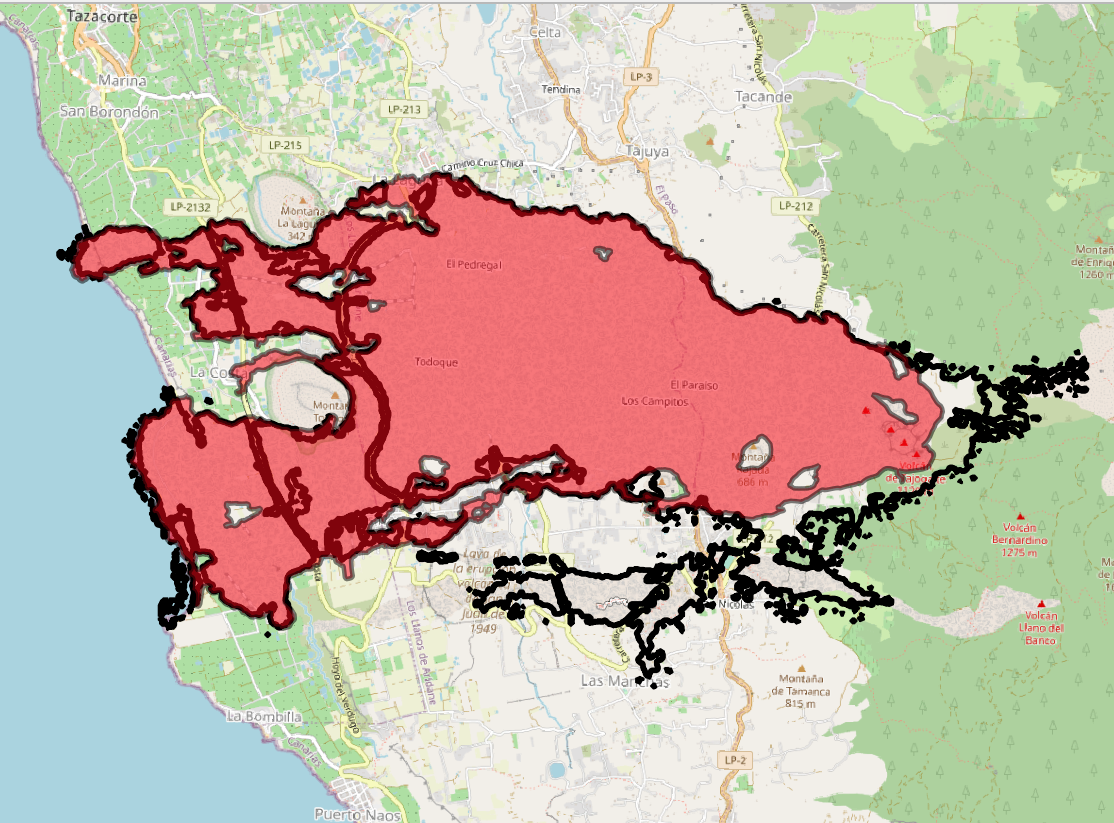

### 5.2 Affected Buildings

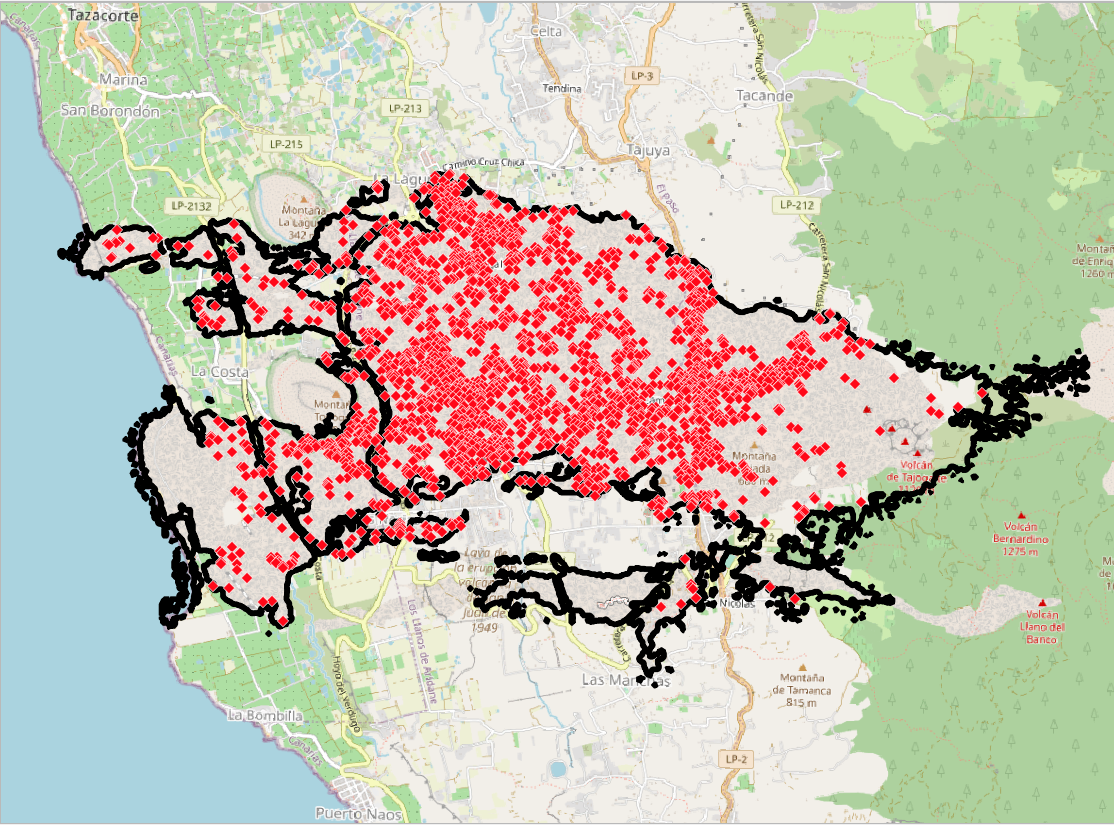

### 5.3 Morphology Change

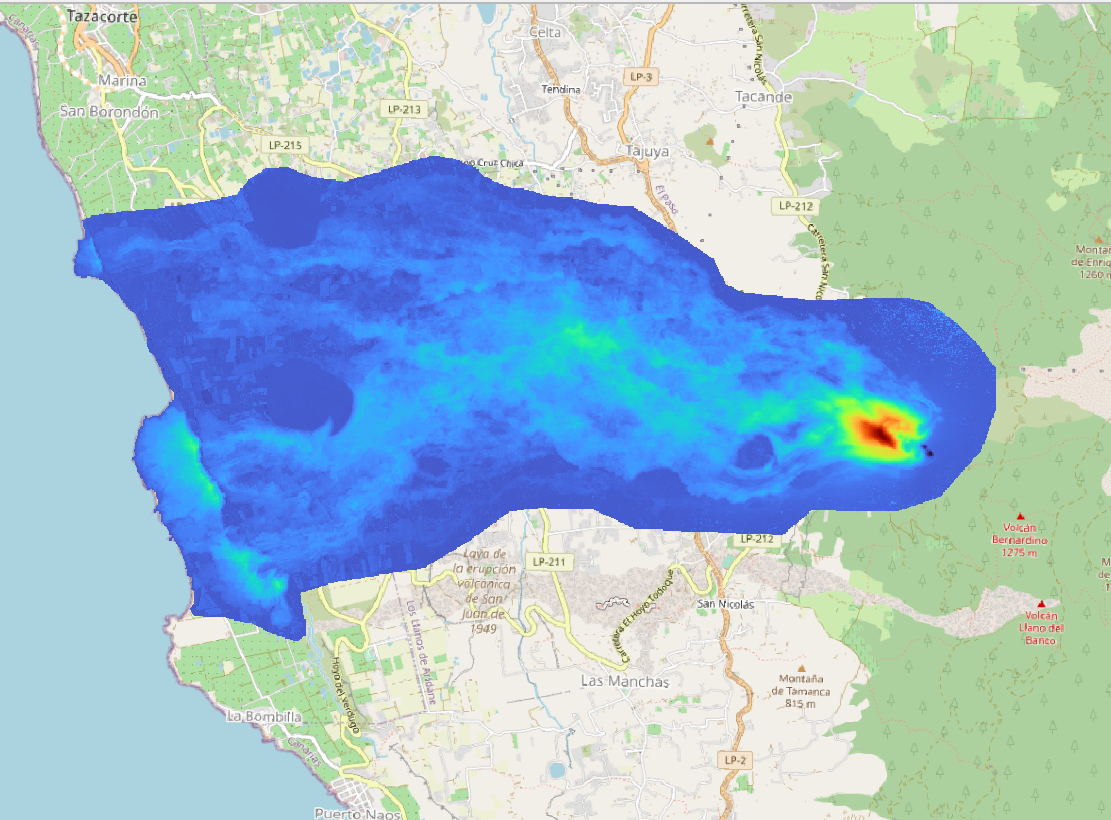